In [1]:
import serial
import threading
import struct
import numpy as np
class tinyDepthInterface:
    def __init__(self, port, boundrate=115200):
        self.ser = serial.Serial(port, boundrate, timeout=1)
        if not self.ser.isOpen():
            print("Error: Serial port not open")
            return
        self.daq_thread = threading.Thread(target=self.daq_thread)
        self._depthImage = None 
        self._pointCloud = None
        self.running = True
        self.msg_format = '64H'
        self.daq_thread.start() 

    def close(self):
        self.ser.close()
        self.running = False

    def daq_thread(self):
        while self.running:
            data = self.ser.read_until(b'abc\n')
            if len(data) == 64*2+4:
                self._depthImage = struct.unpack(self.msg_format, data[:-4])
                self._depthImage = np.array(self._depthImage).reshape(8,8)
                self._pointCloud = np.zeros((8,8,3))
                
            else:
                print("Error: invalid data, closing connection")
                self.close()
            
    def getDeothImage(self):
        return None

In [2]:
interface = tinyDepthInterface(port='/dev/ttyACM0',boundrate=115200)

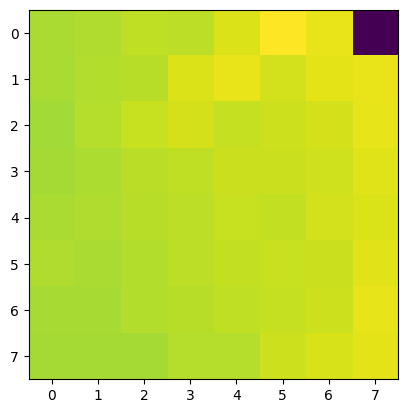

In [3]:
import matplotlib.pyplot as plt
plt.imshow(interface._depthImage)

In [4]:
import numpy as np
from math import sin, cos, pi

# Predefined pitch and yaw angles for 8x8 zones
VL53L5_Zone_Pitch8x8 = np.array([
    59.00, 64.00, 67.50, 70.00, 70.00, 67.50, 64.00, 59.00,
    64.00, 70.00, 72.90, 74.90, 74.90, 72.90, 70.00, 64.00,
    67.50, 72.90, 77.40, 80.50, 80.50, 77.40, 72.90, 67.50,
    70.00, 74.90, 80.50, 85.75, 85.75, 80.50, 74.90, 70.00,
    70.00, 74.90, 80.50, 85.75, 85.75, 80.50, 74.90, 70.00,
    67.50, 72.90, 77.40, 80.50, 80.50, 77.40, 72.90, 67.50,
    64.00, 70.00, 72.90, 74.90, 74.90, 72.90, 70.00, 64.00,
    59.00, 64.00, 67.50, 70.00, 70.00, 67.50, 64.00, 59.00
])

VL53L5_Zone_Yaw8x8 = np.array([
    135.00, 125.40, 113.20, 98.13, 81.87, 66.80, 54.60, 45.00,
    144.60, 135.00, 120.96, 101.31, 78.69, 59.04, 45.00, 35.40,
    156.80, 149.04, 135.00, 108.45, 71.55, 45.00, 30.96, 23.20,
    171.87, 168.69, 161.55, 135.00, 45.00, 18.45, 11.31, 8.13,
    188.13, 191.31, 198.45, 225.00, 315.00, 341.55, 348.69, 351.87,
    203.20, 210.96, 225.00, 251.55, 288.45, 315.00, 329.04, 336.80,
    214.60, 225.00, 239.04, 258.69, 281.31, 300.96, 315.00, 324.60,
    225.00, 234.60, 246.80, 261.87, 278.13, 293.20, 305.40, 315.00
])

def convert_depth_to_pointcloud(depth_array):
    # Initialize the sine and cosine tables
    SinOfPitch = np.sin(np.deg2rad(VL53L5_Zone_Pitch8x8))
    CosOfPitch = np.cos(np.deg2rad(VL53L5_Zone_Pitch8x8))
    SinOfYaw = np.sin(np.deg2rad(VL53L5_Zone_Yaw8x8))
    CosOfYaw = np.cos(np.deg2rad(VL53L5_Zone_Yaw8x8))
    
    # Prepare the point cloud array
    point_cloud = np.zeros((64, 3))
    
    for ZoneNum in range(64):
        if depth_array.flatten()[ZoneNum] > 0:  # Assuming depth_array is the input 8x8 numpy array
            Hyp = depth_array.flatten()[ZoneNum] / SinOfPitch[ZoneNum]
            X = CosOfYaw[ZoneNum] * CosOfPitch[ZoneNum] * Hyp
            Y = SinOfYaw[ZoneNum] * CosOfPitch[ZoneNum] * Hyp
            Z = depth_array.flatten()[ZoneNum]
            point_cloud[ZoneNum] = [X, Y, Z]
        else:
            point_cloud[ZoneNum] = [0, 0, 0]
    
    return point_cloud

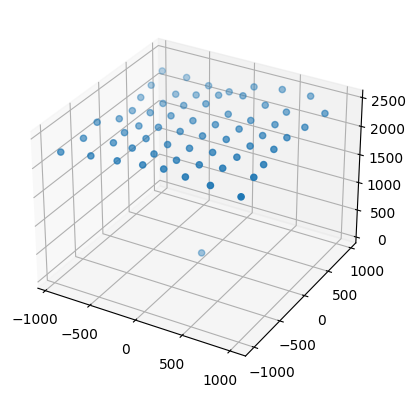

In [5]:
pc = convert_depth_to_pointcloud(interface._depthImage)
# 3d plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2])
plt.show()

In [14]:
# rerun visualization
import rerun 
rerun.init('tinydepth_visualization')
rerun.spawn()

[2024-03-07T03:20:21Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-03-07T03:20:21Z WARN  wgpu_hal::vulkan::instance] Unable to find extension: VK_EXT_swapchain_colorspace
MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0

[2024-03-07T03:20:21Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 12.0.0, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 21.2.6 (LLVM 12.0.0)", vendor: 0x10005}, {backend: Vulkan, device_type: IntegratedGpu, name: "Intel(R) Graphics (RKL GT1)", driver: "Intel open-source Mesa driver", driver_info: "Mesa 21.2.6", vendor: 0x8086, device: 0x4C8A}, {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA GeForce RTX 2080 Ti", driver: "NVIDIA", driver_info: "520.61.05", vendor: 0x10DE, device: 0x1E04}
[2024-03-07T03:20:21Z INFO  tracing::span] perform;
[2024-03-07T03:20:21Z INFO  zbus::handshake] write_command

In [16]:
import time
while True:
    pc = convert_depth_to_pointcloud(interface._depthImage)
    rerun.log('/tinydepth/pointcloud', rerun.Points3D(pc/1000.,radii=np.ones(64)*0.003))
    time.sleep(0.1)